<img src="borat.png" alt="Alt text that describes the graphic" title="Title text" />
***
***
# Studying the ``Layering`` simplificiation with the Hauraki case study: 
# Reduced layering as a simplification

## benefits include:
>### - less run time
>### - fewer unknowns
>### - easier model construction

## but how does this affect predictive results?
>### here we focus only on water quality outputs...

In [1]:
from __future__ import print_function
import os
import ipywidgets as ipyw
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipyleaflet as ipyl
import IPython
import warnings
warnings.filterwarnings("ignore")
import json
from json import dumps
import numpy as np
import pandas as pd
import flopy
d = "31july2018_data"

In [2]:
rowcols = ["62_23","53_39","106_48","09_24","12_20","16_10"]
line = {"column":26}
with open(os.path.join(d,"sire_sfr.json"),"r") as f:
    sfr_data = json.load(f)
with open(os.path.join(d,"sire_grid.json"),"r") as f:
    ucn_data = json.load(f)   
for i,feature in enumerate(ucn_data["features"]):
    #print(feature)
    rc = "{0:02d}_{1:02d}".format(feature["properties"]["row"],feature["properties"]["column"])
    #print(rc)
    #break
    color = "#676565"
    fo = 0.01
    if rc in rowcols:
        color = "#FF0000"
        fo = 1.0
    elif feature["properties"]["column"] == line["column"]:
        color = "#0000FF"
        fo = 1.0
    ucn_data["features"][i]["properties"]["style"]["fillColor"] = color
    ucn_data["features"][i]["properties"]["style"]["color"] = color
    ucn_data["features"][i]["properties"]["style"]["weight"] = 2.0
    ucn_data["features"][i]["properties"]["style"]["fillOpacity"] = fo
    
    
map = ipyl.Map(center=[-37.65,175.65], zoom=10,layout=ipyw.Layout(height="10in",width="6in"))
geo = ipyl.GeoJSON(data=ucn_data)
map.add_layer(geo) 
geo = ipyl.GeoJSON(data=sfr_data)
map.add_layer(geo)

## Quantities of interest:
>### - load (kg) to Firth
>### - SW concentration Piako near Morrinsville
>### - SW concentration Waihou near Waihou
>### - SW concentration near Blue Spring

In [3]:
map

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors', 'max_zoom': 19}, center=[-37.65, 175.65], layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=['attribution', 'min_zoom', 'detect_retina', 'tile_size', 'max_zoom']), GeoJSON(data={'type': 'FeatureCollection', 'features': [{'geometry': {'type': 'Polygon', 'coordinates': [[[175.27298673145768, -37.09654531744868], [175.27325598854853, -37.10555248072564], [175.28450160076966, -37.105336240148745], [175.28423101450304, -37.09632914707807], [175.27298673145768, -37.09654531744868]]]}, 'type': 'Feature', 'properties': {'snb': 0.0, 'other': 0.0, 'lt_tot': 0.0, 'row': 1, 'forestry': 0.0, 'hort_frac': 0.0, 'Nkgm2d': 0.0, 'hort': 0.0, 'forestry_f': 0.0, 'lt_fr_tot': 0.0, 'column': 1, 'rowcol': '001_001', 'dairy_frac': 0.0, 'style': {'fillOpacity': 0.01, 'fillColor': '#676565', 'weight': 2.0, 'opacity': 0.25, 'color': '#676565'}, 'dairy': 0.0, 'snb_frac': 0.0, 'other_frac': 0.0}}, {'geometry': {'type': 'Polygon', 'coordinates': [[[175.28423101450304, -37.09632914707807], [175.28450160076966, -37.105336240148745], [175.29574709265205, -37.105118934133586], [175.29547517726556, -37.09611191161473], [175.28423101450304, -37.09632914707807]]]}, 'type': 'Feature', 'properties': {'snb': 0.0, 'other': 0.0, 'lt_tot': 0.0, 'row': 1, 'forestry': 0.0, 'hort_frac': 0.0, 'Nkgm2d': 0.0, 'hort': 0.0, 'forestry_f': 0.0, 'lt_fr_tot': 0.0, 'column': 2, 'rowcol': '001_002', 'dairy_frac': 0.0, 'style': {'fillOpacity': 0.01, 'fillColor': '#676565', 'weight': 2.0, 'opacity': 0.25, 'color': '#676565'}, 'dairy': 0.0, 'snb_frac': 0.0, 'other_frac': 0.0}}, {'geometry': {'type': 'Polygon', 'coordinates': [[[175.29547517726556, -37.09611191161473], [175.29574709265205, -37.105118934133586], [175.30699246360558, -37.10490056271585], [175.30671921915544, -37.09589361109429], [175.29547517726556, -37.09611191161473]]]}, 'type': 'Feature', 'properties': {'snb': 0.0, 'other': 0.0, 'lt_tot': 0.0, 'row': 1, 'forestry': 0.0, 'hort_frac': 0.0, 'Nkgm2d': 0.0, 'hort': 0.0, 'forestry_f': 0.0, 'lt_fr_tot': 0.0, 'column': 3, 'rowcol': '001_003', 'dairy_frac': 0.0, 'style': {'fillOpacity': 0.01, 'fillColor': '#676565', 'weight': 2.0, 'opacity': 0.25, 'color': '#676565'}, 'dairy': 0.0, 'snb_frac': 0.0, 'other_frac': 0.0}}, {'geometry': {'type': 'Polygon', 'coordinates': [[[175.30671921915544, -37.09589361109429], [175.30699246360558, -37.10490056271585], [175.31823771304028, -37.10468112593134], [175.3179631395829, -37.09567424555257], [175.30671921915544, -37.09589361109429]]]}, 'type': 'Feature', 'properties': {'snb': 0.0, 'other': 0.0, 'lt_tot': 0.0, 'row': 1, 'forestry': 0.0, 'hort_frac': 0.0, 'Nkgm2d': 0.0, 'hort': 0.0, 'forestry_f': 0.0, 'lt_fr_tot': 0.0, 'column': 4, 'rowcol': '001_004', 'dairy_frac': 0.0, 'style': {'fillOpacity': 0.01, 'fillColor': '#676565', 'weight': 2.0, 'opacity': 0.25, 'color': '#676565'}, 'dairy': 0.0, 'snb_frac': 0.0, 'other_frac': 0.0}}, {'geometry': {'type': 'Polygon', 'coordinates': [[[175.3179631395829, -37.09567424555257], [175.31823771304028, -37.10468112593134], [175.32948284036604, -37.10446062381611], [175.3292069379582, -37.095453815025586], [175.3179631395829, -37.09567424555257]]]}, 'type': 'Feature', 'properties': {'snb': 0.0, 'other': 0.0, 'lt_tot': 0.0, 'row': 1, 'forestry': 0.0, 'hort_frac': 0.0, 'Nkgm2d': 0.0, 'hort': 0.0, 'forestry_f': 0.0, 'lt_fr_tot': 0.0, 'column': 5, 'rowcol': '001_005', 'dairy_frac': 0.0, 'style': {'fillOpacity': 0.01, 'fillColor': '#676565', 'weight': 2.0, 'opacity': 0.25, 'color': '#676565'}, 'dairy': 0.0, 'snb_frac': 0.0, 'other_frac': 0.0}}, {'geometry': {'type': 'Polygon', 'coordinates': [[[175.3292069379582, -37.095453815025586], [175.32948284036604, -37.10446062381611], [175.34072784499295, -37.104239056406314], [175.34045061369162, -37.09523231954949], [175.3292069379582, -37.095453815025586]]]}, 'type': 'Feature', 'proper

# Approach: chop off the bottom of the Hauraki 7-layer model and form a 1-layer model out of remaining layers:

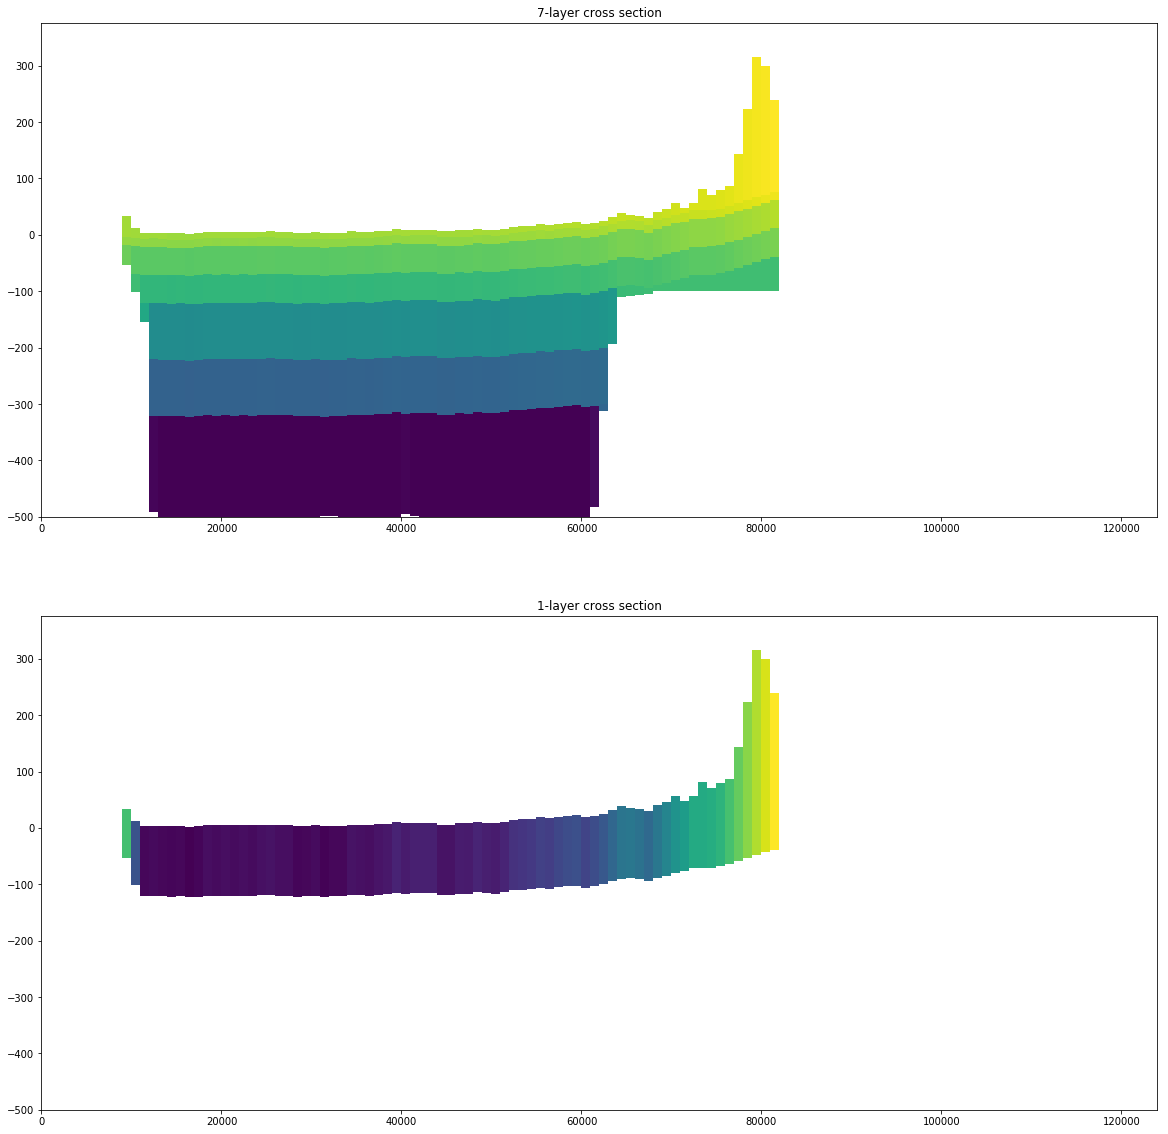

In [4]:

m = flopy.modflow.Modflow.load("BH.nam",model_ws="31july2018_data",load_only=[],check=False)
fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot(211)
ax1.set_title("7-layer cross section")
xs = flopy.plot.ModelCrossSection(model=m,line=line,ax=ax1)
arr = m.dis.botm.array
arr[m.bas6.ibound.array==0] = 1.0E+10
xs.plot_array(arr,masked_values=[1.0e+10]);
ax2 = plt.subplot(212)
ax2.set_title("1-layer cross section")
arr[4:,:,:] = 1.0e+10
for k in range(4):
    arr[k,:,:] = m.dis.botm[3].array
arr[m.bas6.ibound.array==0] = 1.0e+10
xs = flopy.plot.ModelCrossSection(model=m,line=line,ax=ax2)
xs.plot_array(arr,masked_values=[1.0e+10]);

# History matching and uncertainty quantification

## parameterization 
### both models used a combined parameterization approach for spatially-distributed properties:
>#### - zones based on a geologic model for the Hauraki plains
>#### - grid-scale multipliers to account for cell-by-cell variatbility
>#### - 7-layer model: 140K parameters, 1-layer model: 30K parameters

## Both models matched to GW levels, SW fluxes, GW N concentrations, GW Tr concentrations
>#### - the iterative ensemble smoother ``pestpp-ies`` was used for history matching

In [5]:
IPython.display.IFrame(os.path.join("31july2018_data","7layer_1to1.pdf"), width=1000, height=400)

In [6]:
IPython.display.IFrame(os.path.join("31july2018_data","1layer_1to1.pdf"), width=1000, height=400)

### Ruh-Roh:  what happened to the ``Tr`` observations...foreshadowing???


# predictive scenarios

## 3 scenarios: starting with simulated current (2018) nitrate concentrations, run forward 10 years:
>### - ``base``: current N loading and GW abstraction
>### - ``10kg``: 10% reduction in N loading
>### - ``20kg``: 20% reduction in N loading

## _Important_: we are talking about stochastics, so each scenario involves running the model 100 times (once for each realization).  Each of the 100 realizations has its own history-matched parameters, including initial nitrate concentrations from end of the history matching.

## _Important_: we are talking about Bayesian concepts, so each scenario has 100 "prior" realizations and 100 "posterior" realizations.  It is important to understand how the model's predictive ability has changed through history matching.  

## _Summing it all up_: each scenario plot has 4 distributions: prior and posterior for 7-layer and 1-layer models.  Confused yet?




# Absolute outcomes

### direct outputs from the simulations

# Firth:
### green: 7 layer; blue: 1 layer; hatched: prior; solid: posterior

In [15]:
IPython.display.IFrame(os.path.join("31july2018_data","daily_flux_to_Firth_after_10yrs.pdf"), width=800, height=800)

## Comments:
>#### - 1-layer model prior includes some extreme values compared to the 7-layer model
>#### - history matching pushes these extreme values closer to the 7-layer results
>#### - the posterior 1-layer distribtion is centered on higher values compared to the 7-layer model
>#### - history matching didn't change the central tendency of the 7-layer model, only increased our confidence in the central tendacy

# Blue Spring
### green: 7 layer; blue: 1 layer; hatched: prior; solid: posterior

In [16]:
IPython.display.IFrame(os.path.join("31july2018_data","SW_nitrate_concen_at_blue_spring_after_10yrs.pdf"), width=800, height=800)

## Comments:
>#### - both the 7-layer and 1-layer priors are skewed heavily towards very low concetrations
>#### - the 7-layer posterior distribution is in the range of plausible concentrations at blue springs
>#### - the 1-layer posterior distribution is very tightly clustered around 0.0 mg/l #frowny_face

# Piako near Morrinsville
### green: 7 layer; blue: 1 layer; hatched: prior; solid: posterior

In [9]:
IPython.display.IFrame(os.path.join("31july2018_data","SW_nitrate_concen_at_Piako_near_Morrinsville_after_10yrs.pdf"), width=800, height=800)

## Comments:
>#### - the 1-layer and 7-layer posteriors are nearly commensurate
>#### - history matching has pushed both models to substantially higher concentrations
>#### - I think these concentrations are too high...
>#### - the 1-layer prior is much wider than the 7-layer

# Waihou near Waihou
### green: 7 layer; blue: 1 layer; hatched: prior; solid: posterior

In [17]:
IPython.display.IFrame(os.path.join("31july2018_data","SW_nitrate_concen_at_Waihou_near_Waihou_after_10yrs.pdf"), width=800, height=800)

## Comments
>#### - history matching has pushed the posterior distributions higher (as with the Piako)
>#### - the 1-layer prior is much wider than the 7-layer
>#### - the 7-layer posterior is centered on a slightly higher value than the 1-layer

# Difference outcomes
## how much change in predicted outcomes do the ``20%`` and ``10%`` scenarios yield compared to the ``base`` case?

# Firth:
### green: 7 layer; blue: 1 layer; hatched: prior; solid: posterior

In [18]:
IPython.display.IFrame(os.path.join("31july2018_data","daily_flux_to_Firth_after_10yrs_diff.pdf"), width=800, height=800)

## Comments
>#### - In general, the difference results are similar to the absolute results

# Blue Spring
## green: 7 layer; blue: 1 layer; hatched: prior; solid: posterior

In [19]:
IPython.display.IFrame(os.path.join("31july2018_data","SW_nitrate_concen_at_blue_spring_after_10yrs_diff.pdf"), width=800, height=800)

## Comments:
>#### - posterior 1-layer model greatly under-predicts the change in concentration compared to the 7-layer model

# Piako near Morrinsville
### green: 7 layer; blue: 1 layer; hatched: prior; solid: posterior

In [20]:
IPython.display.IFrame(os.path.join("31july2018_data","SW_nitrate_concen_at_Piako_near_Morrinsville_after_10yrs_diff.pdf"), width=800, height=800)

## Comments
>#### - the 1-layer model is underestimating the results concentration change compared to the 7-layer model

# Waihou near Waihou
## green: 7 layer; blue: 1 layer; hatched: prior; solid: posterior

In [21]:
IPython.display.IFrame(os.path.join("31july2018_data","SW_nitrate_concen_at_Waihou_near_Waihou_after_10yrs_diff.pdf"), width=800, height=800)

## Comments:
>#### - the posterior distributions of both the 1-layer and 7-layer models are commensurate!